# Classifying Press Releases using a Multi-Lingual Model


<!--- This script is based on a tutorial by Philipp Schmid (2020) that can be found [here](https://towardsdatascience.com/bert-text-classification-in-a-different-language-6af54930f9cb). --->

The script uses [Simple Transformers](https://github.com/ThilinaRajapakse/simpletransformers) - an NLP library based on the [Transformers](https://github.com/huggingface/transformers) library by HuggingFace.

<!--- Specifically, we use the pretrained German BERT language model that can be downloaded from the HuggingFace model hub under the title "deepset/gbert-base" [(Chan, Schweter and Möller 2020)](https://arxiv.org/pdf/2010.10906.pdf). It was trained using the OPUS and Wikipedia corpora and has been shown to provide optimal performance. --->

<!--- After fine-tuning the model, we achieved an average accuracy of ?% in a five-fold cross-validation. This constitutes a substantial improvement compared to other models (?%). --->

### We are going to

- install Simple Transformers library
- select a pre-trained model
- load the dataset
- train/fine-tune the model
- evaluate the results of it
- do a cross-validation
- test the accuracy for smaller training datasets


# Install Simple Transformers library 

In [ ]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

     |████████████████████████████████| 221 kB 5.2 MB/s 
     |████████████████████████████████| 2.6 MB 48.8 MB/s 
     |████████████████████████████████| 1.6 MB 50.3 MB/s 
     |████████████████████████████████| 124 kB 69.4 MB/s 
     |████████████████████████████████| 8.0 MB 24.0 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 264 kB 62.4 MB/s 
     |████████████████████████████████| 3.3 MB 58.0 MB/s 
     |████████████████████████████████| 1.2 MB 54.1 MB/s 
     |████████████████████████████████| 636 kB 56.5 MB/s 
     |████████████████████████████████| 895 kB 65.0 MB/s 
     |████████████████████████████████| 170 kB 78.1 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 133 kB 83.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 118 kB 84.6 MB/s 
     |████████████████████████████████| 243 kB 81.0 MB/s 
     |███████████████

simpletransformers==0.61.13


In [ ]:
import os

# Load packages

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from google.colab import drive
import pandas as pd
from simpletransformers.classification import ClassificationModel
import tarfile
from shutil import copyfile
from random import randrange
import torch
import gc
from sklearn.metrics import accuracy_score
import timeit
import numpy as np

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

# Load the dataset

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/scripts-hu/issues/other-countries')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('alldocs.csv')
print(df.columns)
print(df.shape)

Index(['htext', 'label', 'cv_sample', 'country', 'id'], dtype='object')
(8647, 5)


In [ ]:
df['sentence1'][1222]

KeyError: ignored

# Five-fold cross-validation

In order to test the robustness of our results to different compositions of our training and test data, we fine-tune the model on five different sets and evaluate the performance.

In [ ]:
# Prepare five-fold cross-validation

# With threshold
# Define hyperparameter
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 8, 
    'num_train_epochs': 4, 
    'max_seq_length': 512, 
    'save_steps': 5000000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}

# Create a list to store the data of each fold
results = []
times = []
bert_pred = pd.DataFrame()

# Loop over all folds (5)
for i in [1 , 2, 3, 4, 5]:
  print(i)

  # Create train/test df
  train_df = df[(df.cv_sample != i)][['htext','label']]
  print('train shape: ', train_df.shape)
  
  test_df = df[(df.cv_sample == i)][['htext','label']]
  print('test shape: ', test_df.shape)
  
  # Create a ClassificationModel
  model = ClassificationModel(
    "bert", "bert-base-multilingual-cased",
    num_labels= 17,
    use_cuda = True,
    args=train_args
  )
  
  start = timeit.default_timer()

  # Train the model
  model.train_model(train_df)

  # Add the time to the list
  stop = timeit.default_timer()
  times.append((stop - start))

  # Run the evaluation on the test set
  result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=accuracy_score)
  
  print(result['acc'])
  
  # Add the accuracy to the list
  results.append(result['acc'])

  predictions, raw_outputs = model.predict([item for sublist in test_df[['htext']].values.tolist() for item in sublist])
  
  this_bert_pred = pd.DataFrame({'prediction': predictions,
                               'label': np.concatenate(df[(df.cv_sample == i)][['label']].values),
                               'cv_sample': i},
                                index = list(range(0, len(test_df))))
  print(this_bert_pred)
  
  bert_pred = bert_pred.append(this_bert_pred)
  
  np.savetxt("bert-pred.csv", bert_pred, delimiter = ",")

1
train shape:  (7037, 2)
test shape:  (1718, 2)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/7037 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/880 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/880 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/880 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/880 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1718 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/215 [00:00<?, ?it/s]

0.7369033760186263


  0%|          | 0/1718 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

      prediction  label  cv_sample
0              0      0          1
1              0      0          1
2              4      0          1
3              0      0          1
4              0      0          1
...          ...    ...        ...
1713          16     16          1
1714          16     16          1
1715          16     16          1
1716          16     16          1
1717           4     16          1

[1718 rows x 3 columns]
2
train shape:  (6993, 2)
test shape:  (1762, 2)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6993 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1762 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/221 [00:00<?, ?it/s]

0.7383654937570943


  0%|          | 0/1762 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

      prediction  label  cv_sample
0              8      0          2
1              0      0          2
2              0      0          2
3             13      0          2
4              0      0          2
...          ...    ...        ...
1757          16     16          2
1758          11     16          2
1759          16     16          2
1760          16     16          2
1761          16     16          2

[1762 rows x 3 columns]
3
train shape:  (6999, 2)
test shape:  (1756, 2)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/875 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1756 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/220 [00:00<?, ?it/s]

0.744874715261959


  0%|          | 0/1756 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

      prediction  label  cv_sample
0              6      0          3
1              0      0          3
2              0      0          3
3              0      0          3
4              0      0          3
...          ...    ...        ...
1751          16     16          3
1752          16     16          3
1753          16     16          3
1754          16     16          3
1755          16     16          3

[1756 rows x 3 columns]
4
train shape:  (7045, 2)
test shape:  (1710, 2)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/7045 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/881 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/881 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/881 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/881 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1710 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/214 [00:00<?, ?it/s]

0.7210526315789474


  0%|          | 0/1710 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

      prediction  label  cv_sample
0              0      0          4
1              0      0          4
2              0      0          4
3              4      0          4
4              0      0          4
...          ...    ...        ...
1705          16     16          4
1706          13     16          4
1707          16     16          4
1708          16     16          4
1709          16     16          4

[1710 rows x 3 columns]
5
train shape:  (6946, 2)
test shape:  (1809, 2)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6946 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/869 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/869 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/869 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/869 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1809 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/227 [00:00<?, ?it/s]

0.7468214483139857


  0%|          | 0/1809 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

      prediction  label  cv_sample
0              0      0          5
1              0      0          5
2              0      0          5
3              0      0          5
4              0      0          5
...          ...    ...        ...
1804          16     16          5
1805          16     16          5
1806          16     16          5
1807          16     16          5
1808          16     16          5

[1809 rows x 3 columns]


The average accuracy is:

In [ ]:
results # print(f'Average accuracy: {sum(results)/5}')

In [ ]:
accuracy_score(predictions, np.concatenate(df[(df.cv_sample == i)][['label']].values))

In [ ]:
np.savetxt("cv-accuracy.txt", [sum(results)/5], delimiter = ",")
np.savetxt("cv-time.txt", [sum(times)/5], delimiter = ",")

# Test without Spanish PRs in training data…

In [ ]:
nospain = df[df.country != "spain"][['htext','label']]
spain = df[df.country == "spain"][['htext','label']]
print(spain.shape)

(2888, 2)


In [ ]:
nospain = nospain.sample(frac=1)
spain = spain.sample(frac=1)

In [ ]:

# With threshold
# Define hyperparameter
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 8, 
    'num_train_epochs': 4, 
    'max_seq_length': 512, 
    'save_steps': 500000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}

results = []

# Try different sizes
sizes = [5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 1000, 1500, 1750, 2000, 2095]
for i in sizes:
  
  print(i)

  train = pd.concat([nospain, spain[:i]])
  test = spain[(i+1):]

  # Create a ClassificationModel
  model = ClassificationModel(
    "bert", "bert-base-multilingual-cased",
    num_labels= 17,
    use_cuda = True,
    args=train_args
  )
  
  # Train the model
  model.train_model(train)

  # Add the time to the list

  # Run the evaluation on the test set
  result, model_outputs, wrong_predictions = model.eval_model(test, acc=accuracy_score)
  
  print(result['acc'])

  results.append(result['acc'])

5


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/5764 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/721 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/721 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/721 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/721 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2882 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/361 [00:00<?, ?it/s]

0.6533657182512145
25


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/5784 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/723 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/723 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/723 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/723 [00:00<?, ?it/s]

  0%|          | 0/2862 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/358 [00:00<?, ?it/s]

0.6607267645003494
50


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/5809 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/727 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/727 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/727 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/2837 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/355 [00:00<?, ?it/s]

0.6633768064857244
100


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/5859 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/733 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/733 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/733 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/2787 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/349 [00:00<?, ?it/s]

0.6838894869034804
200


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/5959 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/745 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/745 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/745 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/2687 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/336 [00:00<?, ?it/s]

0.6929661332340901
300


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6059 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/758 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/758 [00:00<?, ?it/s]

  0%|          | 0/2587 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

0.7004252029377658
400


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6159 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/770 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/770 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/770 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/770 [00:00<?, ?it/s]

  0%|          | 0/2487 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/311 [00:00<?, ?it/s]

0.7100924809006836
500


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6259 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/783 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/783 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/783 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/783 [00:00<?, ?it/s]

  0%|          | 0/2387 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/299 [00:00<?, ?it/s]

0.7205697528278173
600


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6359 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/795 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/795 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/795 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/795 [00:00<?, ?it/s]

  0%|          | 0/2287 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/286 [00:00<?, ?it/s]

0.7101005684302579
700


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6459 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/808 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/808 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/808 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/808 [00:00<?, ?it/s]

  0%|          | 0/2187 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/274 [00:00<?, ?it/s]

0.7082761774119799
1000


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/6759 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/845 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/845 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/845 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/1887 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/236 [00:00<?, ?it/s]

0.7223105458399576
1500


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/7259 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/908 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/908 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/908 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/1387 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/174 [00:00<?, ?it/s]

0.7202595529920692
1750


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/7509 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/939 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/939 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/939 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/939 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/143 [00:00<?, ?it/s]

0.7335092348284961
2000


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/7759 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/970 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/970 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/970 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/111 [00:00<?, ?it/s]

0.7452085682074409
2095


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

  0%|          | 0/7854 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/982 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/982 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/982 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/982 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/99 [00:00<?, ?it/s]

0.7525252525252525


In [ ]:
results = [0.6533657182512145,
 0.6607267645003494,
 0.6633768064857244,
 0.6838894869034804,
 0.6929661332340901,
 0.7004252029377658,
 0.7100924809006836,
 0.7205697528278173,
 0.7101005684302579,
 0.7082761774119799,
 0.7223105458399576,
 0.7202595529920692,
 0.7335092348284961,
 0.7452085682074409,
 0.7525252525252525]
#sizes = [5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 1000, 1500, 1750, 2000, 2095]

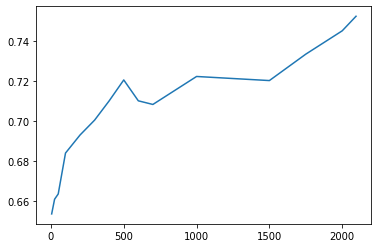

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sizes, results)

In [ ]:
np.savetxt("results-training-size.csv", pd.DataFrame({'accuracy': results, 'sizes': sizes}), delimiter = ",")

# Classify unlabeled data

> UNDER CONSTRUCTION


## Load and train model

In [ ]:
# Create train (all labeled)
train_df = df[df.issue_r1!= -1][['htext','label']]
print('train shape: ', train_df.shape)


In [ ]:
# Define hyperparameters
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 16, 
    'num_train_epochs': 4, 
    'max_seq_length': 512, 
    'save_steps': 500000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}


# Create a ClassificationModel
model = ClassificationModel(
    "bert", "deepset/gbert-base",
    num_labels= 17,
    use_cuda = True,
    args=train_args
)

# Train the model
model.train_model(train_df)

## Save and load the model

Save files in folder "outputs".


In [ ]:
# Save and pack model
def save_model(model_path='',file_name=''):
  files = [files for root, dirs, files in os.walk(model_path)][0]
  with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
    for file in files:
      f.add(f'{model_path}/{file}')
  f.close()

In [ ]:
save_model('outputs','gbert-scripts-issues-german')

In [ ]:
# !tar -zxvf ../transfer-files/germeval-distilbert-german.tar.gz

## Examples for classification

We present a press release and the predicted label. Some examples should be misclassified. Note, however, that these misclassifications often still make some sense.

In [ ]:

# These are our class labels.
# Note that the labels range from 0 to 16 and therefore differ from the CAP labels in the dataset.
class_list = ['MACROECONOMICS', 'CIVIL RIGHTS', 'HEALTH', 'AGRICULTURE','LABOR', 'EDUCATION', 
              'ENVIRONMENT AND ENERGY', 'IMMIGRATION', 'WELFARE', 'LAW AND CRIME', 'COMMERCE', 
              'DEFENSE', 'TECHNOLOGY', 'GOVERNMENT OPS', 'OTHER', 'INTERNATIONAL AFFAIRS', 'EUROPEAN UNION']

# Example
sampledoc = randrange(test_df.shape[0])
test_tweet = test_df["htext"].iloc[sampledoc]
test_label = test_df["label"].iloc[sampledoc]
predictions, raw_outputs = model.predict([test_tweet])
print(test_tweet)
print(f"Prediction: {class_list[predictions[0]]}; Truth: {class_list[test_label]}")


## Load the model

In [ ]:
# Unpack model
def unpack_model(model_name=''): 
  tar = tarfile.open(f"{model_name}.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

unpack_model('gbert-scripts-issues-german')

In [ ]:
# define hyperparameter
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 16, 
    'num_train_epochs': 4, 
    'max_seq_length': 512, 
    'save_steps': 500000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "outputs/",
    num_labels= 17,
    use_cuda = True,
    args=train_args
)

## Predict all labels

In [ ]:
  predictions, raw_outputs = model.predict([item for sublist in df[['htext']].values.tolist() for item in sublist])

In [ ]:
unlabeled_pred = pd.DataFrame({'prediction': predictions,
                                 'id': np.concatenate(df[['id']].values)},
                                index = list(range(0, len(predictions))))

In [ ]:
  np.savetxt("alldocs-pred.csv", unlabeled_pred, delimiter = ",")